# Creating your own dataset from Google Images

*by: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

In this tutorial we will see how to easily create an image dataset through Google Images.

In [0]:
from fastai.vision import *
from fastai.widgets import *

### Search and scroll

Go to [Google Images](http://images.google.com) and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

It is a good idea to put things you want to exclude into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

    "canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis

You can also limit your results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.

## Download images

Choose an appropriate name for your labeled images.

In [0]:
# Setup path and labels to search for
path = Config.data_path()/'cats'
labels = ['black cat', 'gray cat', 'white cat']

Now you will need to download your images.

fast.ai has a function that allows you to do just that. You just have to specify keywords to search on Google Images and this function will download and save all images that can be opened. If they have some problem in being opened, they will not be saved.

Let's download our images! Notice you can choose a maximum number of images to be downloaded. In this case we will not download all the urls.

In [3]:
# Download images
for label in labels: 
    files = download_google_images(path, label, format='jpg', size='>1024*768', n_images=100)

cannot identify image file <_io.BufferedReader name='/root/.fastai/data/cats/black cat/00000062.jpg'>
cannot identify image file <_io.BufferedReader name='/root/.fastai/data/cats/black cat/00000003.jpg'>
cannot identify image file <_io.BufferedReader name='/root/.fastai/data/cats/black cat/00000013.jpg'>
cannot identify image file <_io.BufferedReader name='/root/.fastai/data/cats/black cat/00000043.jpg'>


cannot identify image file <_io.BufferedReader name='/root/.fastai/data/cats/gray cat/00000056.jpg'>


cannot identify image file <_io.BufferedReader name='/root/.fastai/data/cats/white cat/00000062.jpg'>
cannot identify image file <_io.BufferedReader name='/root/.fastai/data/cats/white cat/00000077.jpg'>


In [4]:
# List content of path
path.ls()

[PosixPath('/root/.fastai/data/cats/gray cat'),
 PosixPath('/root/.fastai/data/cats/black cat'),
 PosixPath('/root/.fastai/data/cats/white cat')]

Then we can remove any images that can't be opened:

In [5]:
# Verify images
for label in labels:
    print(label)
    verify_images(path/label, delete=True, max_size=500)

black cat


gray cat


white cat


## View data

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
# If you already cleaned your data, run this cell instead of the one before
# np.random.seed(42)
# data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
#         ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

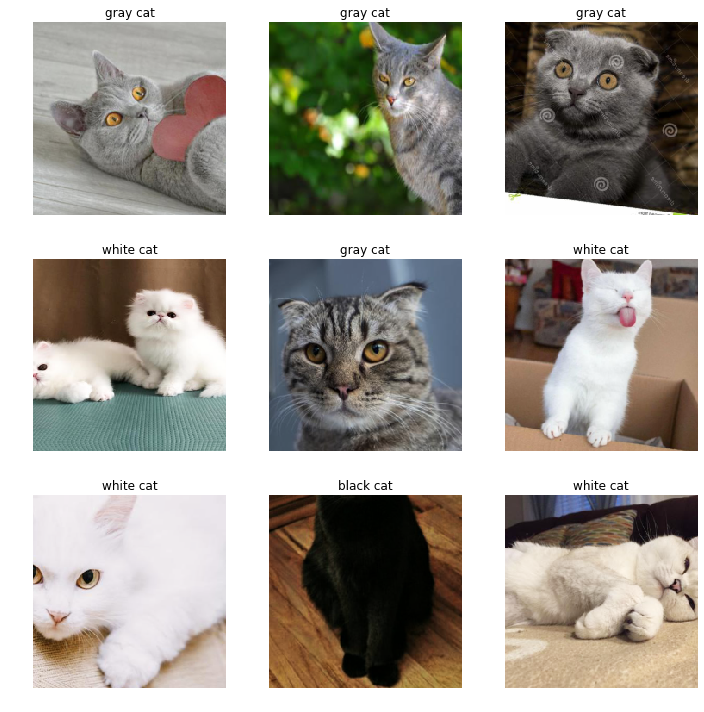

In [8]:
data.show_batch(rows=3, figsize=(10,10))

In [9]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['black cat', 'gray cat', 'white cat'], 3, 213, 53)

## Train model

In [10]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:00, 101625872.16it/s]


In [11]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.544450,1.258015,0.660377,00:04
1,0.977640,0.560237,0.226415,00:04
2,0.700418,0.277480,0.113208,00:04
3,0.544865,0.203408,0.094340,00:04


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


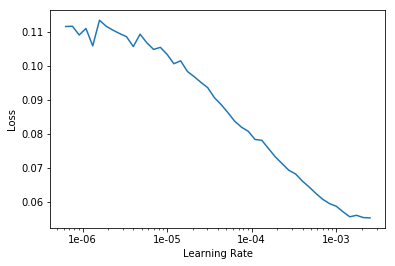

In [15]:
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.137957,0.185313,0.094340,00:04
1,0.100337,0.174166,0.094340,00:04


In [0]:
learn.save('stage-2')

## Interpretation

In [0]:
learn.load('stage-2');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

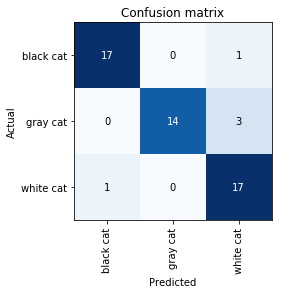

In [20]:
interp.plot_confusion_matrix()

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [0]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [0]:
defaults.device = torch.device('cpu')

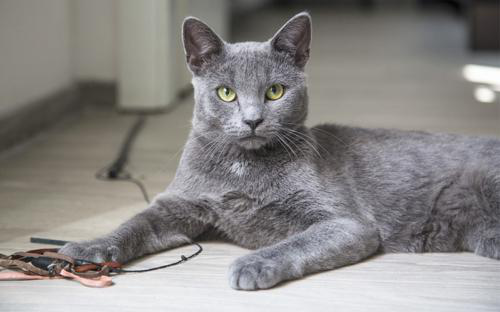

In [23]:
img = open_image(path/'gray cat'/'00000001.jpg')
img

In [24]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class

Category gray cat

We create our `Learner` in production environment like this, just make sure that `path` contains the file 'export.pkl' from before.

In [0]:
learn = load_learner(path)

In [26]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class

Category gray cat

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)

## Things that can go wrong

- Most of the time things will train fine with the defaults
- There's not much you really need to tune (despite what you've heard!)
- Most likely are
  - Learning rate
  - Number of epochs

### Learning rate (LR) too high

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [28]:
learn.fit_one_cycle(1, max_lr=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,3.577976,339585568.000000,0.679245,00:04


### Learning rate (LR) too low

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [30]:
learn.fit_one_cycle(5, max_lr=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,1.528355,1.489275,0.679245,00:03
1,1.541507,1.335485,0.622642,00:04
2,1.466909,1.269755,0.679245,00:03
3,1.480931,1.245236,0.660377,00:04
4,1.487631,1.246055,0.622642,00:04


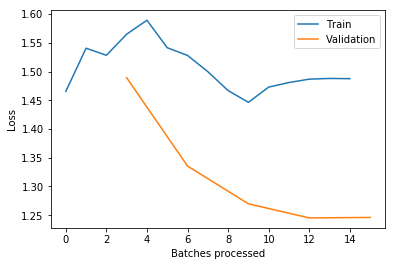

In [31]:
learn.recorder.plot_losses()

As well as taking a really long time, it's getting too many looks at each image, so may overfit.

### Too few epochs

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, pretrained=False)

In [33]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.503827,14.846601,0.660377,00:04


### Too many epochs

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path,
                                  train=".",
                                  valid_pct=0.9,
                                  bs=16,
                                  ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0), 
                                  size=224,
                                  num_workers=4).normalize(imagenet_stats)

In [35]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:00, 104729398.89it/s]


In [36]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.400182,1.353172,0.711297,00:06
1,1.367971,1.325078,0.753138,00:03
2,1.323816,1.298821,0.765690,00:03
3,1.359884,1.266666,0.761506,00:03
4,1.386915,1.240323,0.736402,00:03
5,1.352096,1.216757,0.728033,00:03
6,1.293545,1.184354,0.707113,00:02
7,1.260806,1.142200,0.665272,00:03
8,1.211285,1.085763,0.585774,00:03
9,1.143066,1.024194,0.527197,00:03
